In [1]:
import os
os.chdir('..')

In [2]:
import torch
import json
import time
import string
import argparse
import numpy as np
import pandas as pd
import networkx as nx
from pathlib import Path
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from modules.aagcn import AAGCN, UnitGCN, GraphAAGCN
from modules.data import InfantMotionDataset
from modules.model import AdaptiveSTGCN
from modules.constants import T, N, EDGE_LABELS, EDGE_INDEX, PHYSICAL_EDGE_INDEX, NODE_INDEX

/usr/local/lib64/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/users/dholmber/.local/lib/python3.9/site-packages/torch_geometric/typing.py:47: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/users/dholmber/.local/lib/python3.9/site-packages/torch_geometric/typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(
/users/dholmber/.local/lib/python3.9/site-packages/torch_geometric/typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings

## Read in a Model

In [3]:
age_data = pd.read_csv('metadata/combined.csv', dtype={'test_id': str})
fts_data = pd.read_csv('data/features.csv')

output_dir = 'results/aagcn/fold_4'

with open(os.path.join(output_dir, 'metadata.json'), 'r') as f:
    metadata = json.load(f)

args = metadata['args']

streams = args['streams'].split(',')
xy_data = metadata['args']['xy_data']
edge_index = torch.tensor(PHYSICAL_EDGE_INDEX) if metadata['args']['physical_edges'] else torch.tensor(EDGE_INDEX)

model = AdaptiveSTGCN.load_from_checkpoint(
    checkpoint_path=f'{output_dir}/best_model.ckpt',
    in_channels=2*len(streams) if xy_data else 3*len(streams),
    out_channels=32,
    edge_index=edge_index,
    num_nodes=N,
    learning_rate=args['learning_rate'],
    adaptive=args['adaptive'],
    attention=args['attention'],
    masking=args['masking'],
    concat_features=args['concat_features'],
    store_graphs=True,
    store_attention=True,
)
model.eval()

Lightning automatically upgraded your loaded checkpoint from v1.8.3 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint results/aagcn/fold_4/best_model.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.8.3 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint results/aagcn/fold_4/best_model.ckpt`


AdaptiveSTGCN(
  (data_bn): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): AAGCN(
    (gcn): UnitGCN(
      (conv_d): ModuleList(
        (0-2): 3 x Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_a): ModuleList(
        (0-2): 3 x Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_b): ModuleList(
        (0-2): 3 x Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_ta): Conv1d(32, 1, kernel_size=(9,), stride=(1,), padding=(4,))
      (conv_sa): Conv1d(32, 1, kernel_size=(17,), stride=(1,), padding=(8,))
      (fc1c): Linear(in_features=32, out_features=16, bias=True)
      (fc2c): Linear(in_features=16, out_features=32, bias=True)
      (down): Sequential(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_run

## Visualize Adjacency Matrix

In [4]:
aagcn_graph = GraphAAGCN(edge_index, N)
original_graph = np.array(aagcn_graph.A)

In [5]:
def extract_learned_graph_weights(model):
    learned_graphs = []

    for layer in model.children():
        if isinstance(layer, AAGCN):
            learned_graphs.append(layer.A.detach().cpu().numpy())
            
    return learned_graphs

learned_graphs = extract_learned_graph_weights(model)

diffs = []
for i in range(4):
    diffs.append(learned_graphs[i] - original_graph)

In [6]:
def plot_adjacency_matrix(A):
    #A_min = A.min()
    #A_max = A.max()
    #A = (A - A_min) / (A_max - A_min)
    fig, ax = plt.subplots(figsize=(7,7))
    cax = ax.matshow(A, cmap='viridis', interpolation='none')
    
    # Set node labels from the NODE_INDEX dictionary for both x and y axes
    labels = list(NODE_INDEX.keys())
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)  # rotate x labels for better visualization
    ax.set_yticklabels(labels)
    
    plt.colorbar(cax)
    plt.show()

A is shape: (3 for self-links, inward-links, and outward-links, num_nodes, num_nodes)

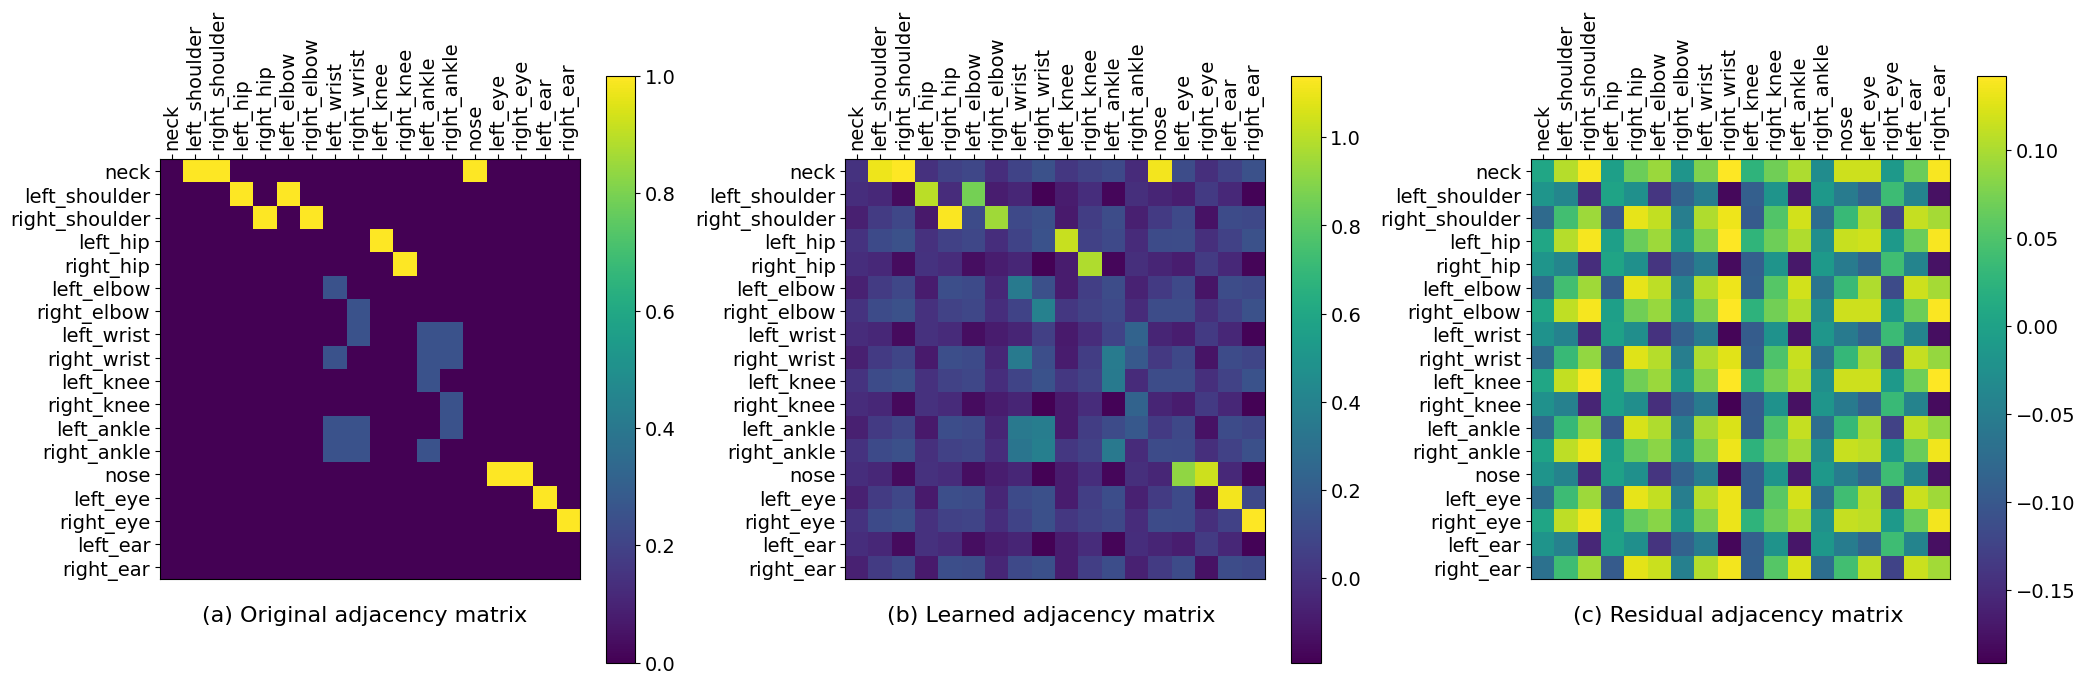

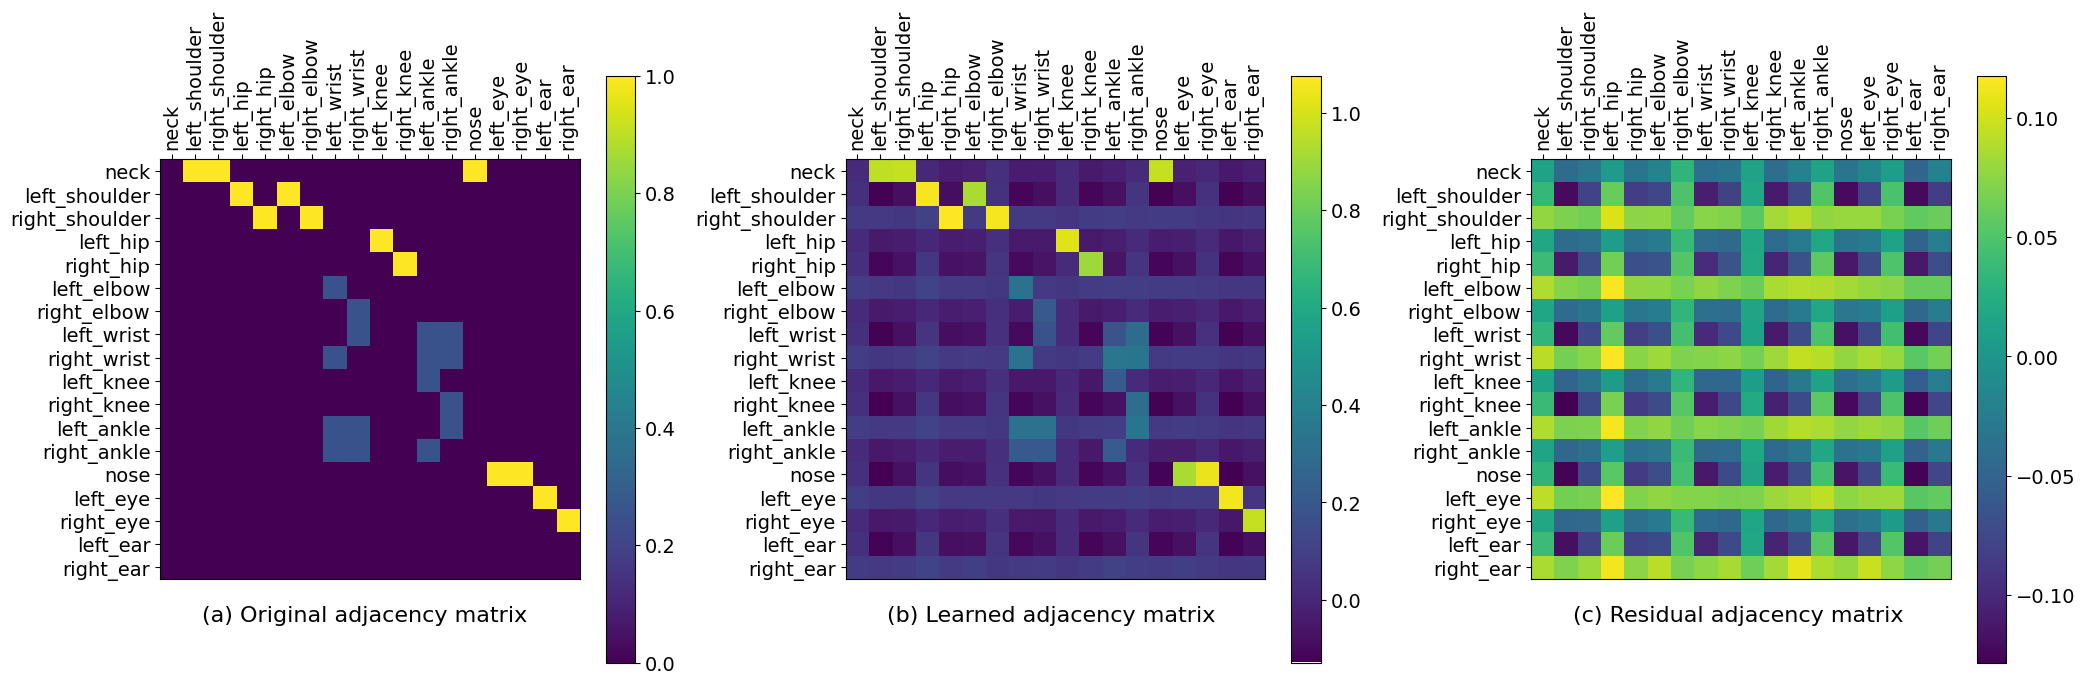

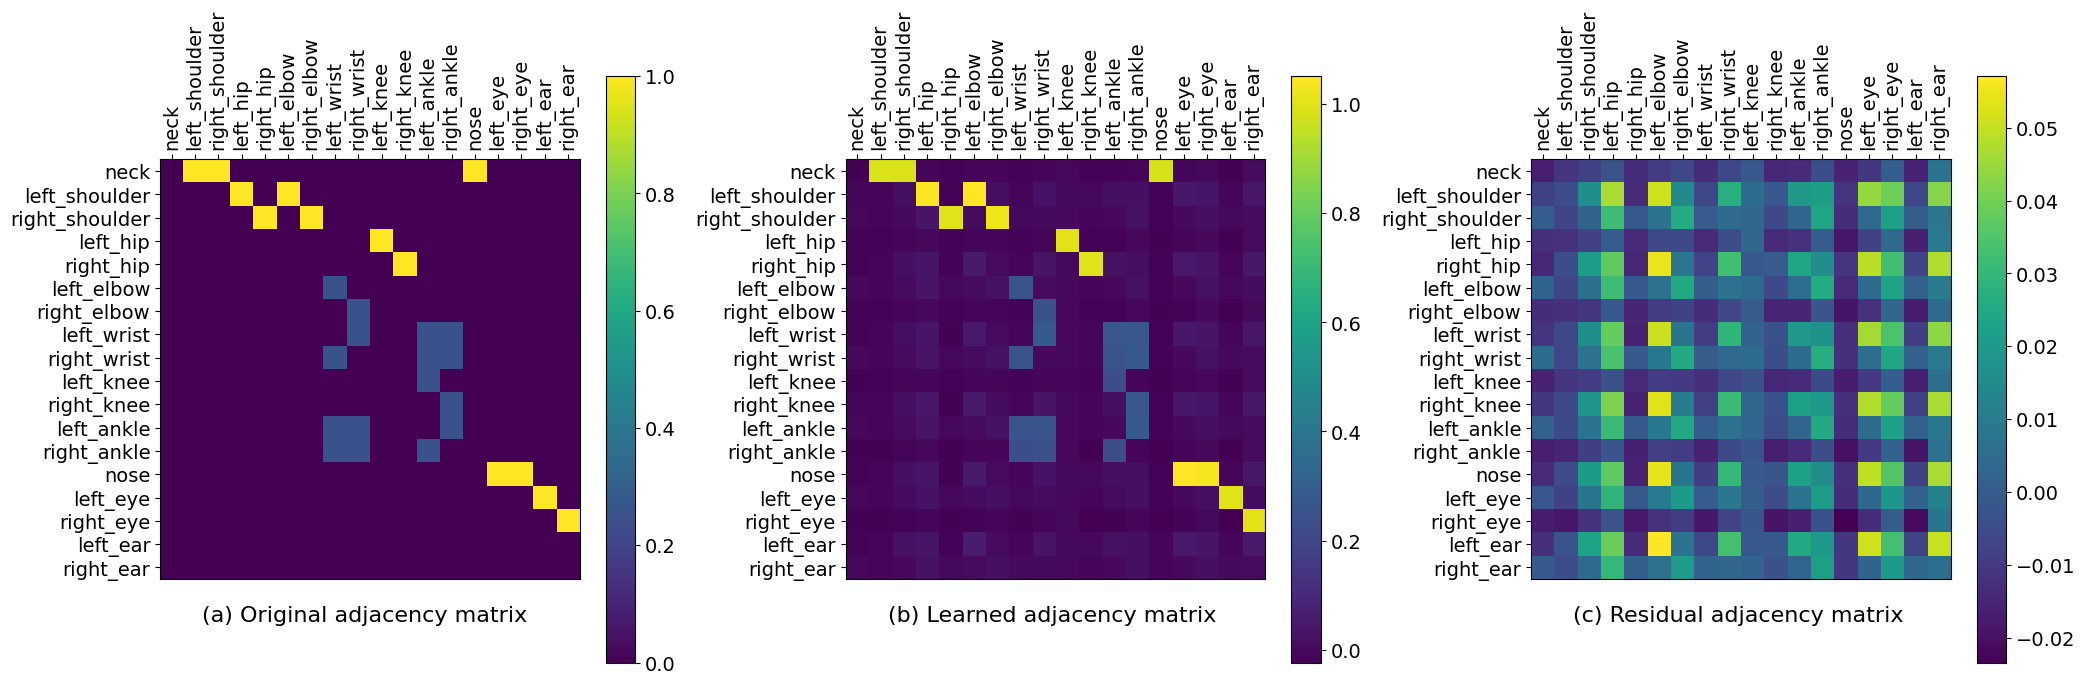

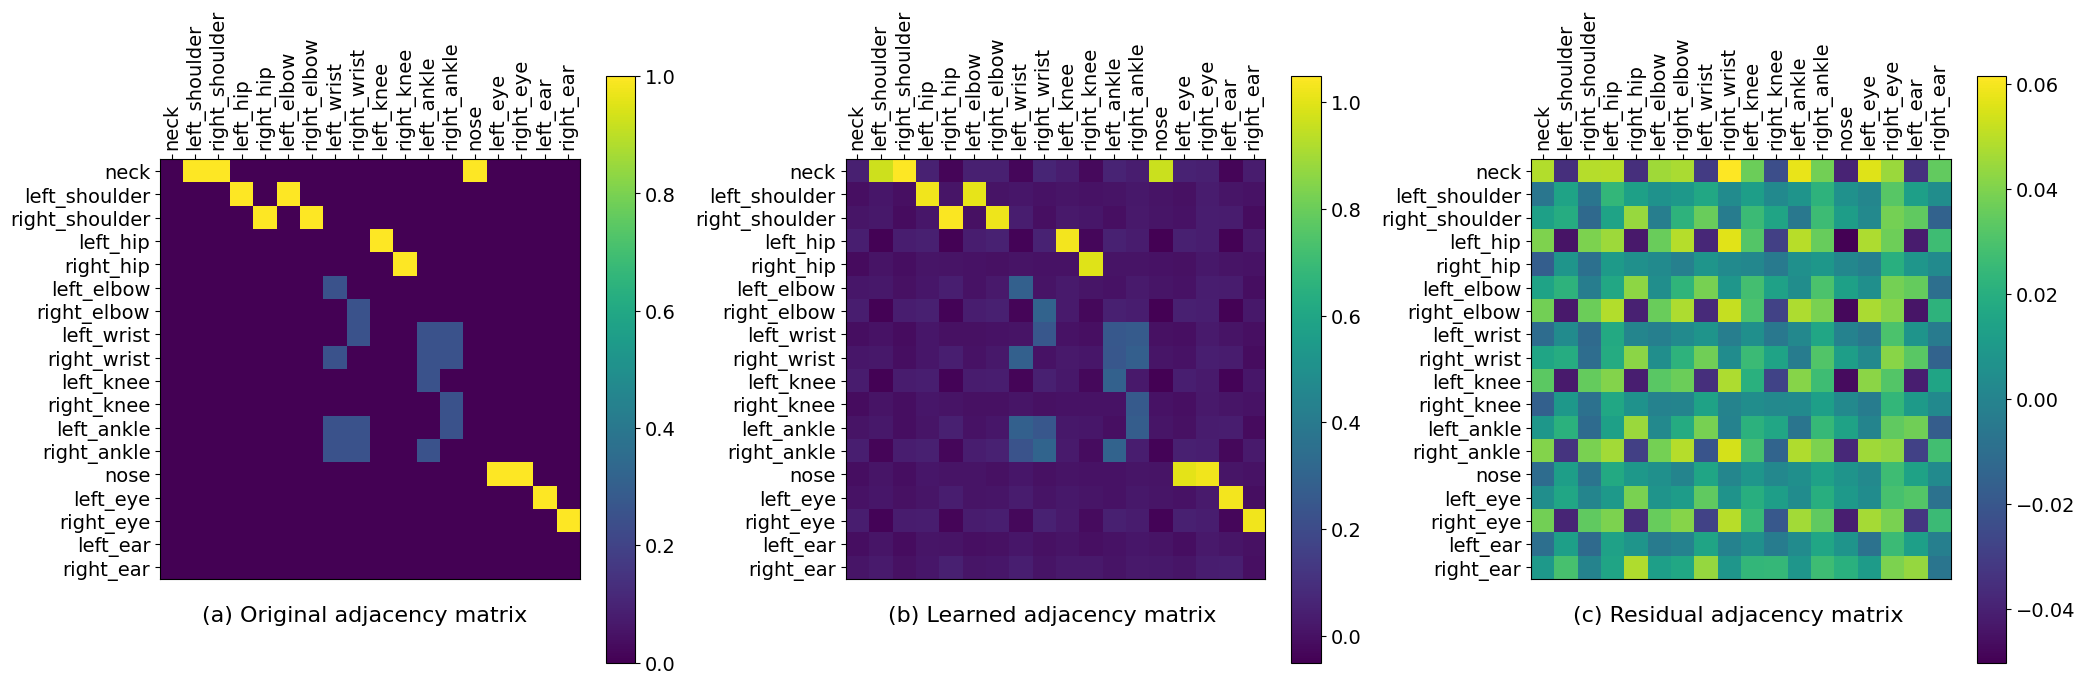

In [7]:
def plot_adjacency_matrix(ax, A, axis_text):
    cax = ax.matshow(A, cmap='viridis', interpolation='none')
    cbar = fig.colorbar(cax, ax=ax)
    cbar.ax.tick_params(labelsize=14)
    labels = list(NODE_INDEX.keys())
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize=14)
    ax.set_yticklabels(labels, fontsize=14)
    ax.tick_params(axis='x', bottom=False)
    ax.text(0.1, -0.1, axis_text, transform=ax.transAxes, fontsize=16)

    
for i in range(len(learned_graphs)):
    fig, axs = plt.subplots(1, 3, figsize=(21, 7))

    # Original Graph
    plot_adjacency_matrix(axs[0], original_graph[1,:,:], '(a) Original adjacency matrix')

    # Learned Graph
    plot_adjacency_matrix(axs[1], learned_graphs[i][1,:,:], '(b) Learned adjacency matrix')

    # Difference
    diff = learned_graphs[i][1,:,:] - original_graph[1,:,:]
    plot_adjacency_matrix(axs[2], diff, '(c) Residual adjacency matrix')

    plt.tight_layout()

    for ext in ['png', 'pdf', 'eps']:
        plt.savefig(f'figures/adjacency_matrix_{i+1}.{ext}', dpi=300)
    plt.show()

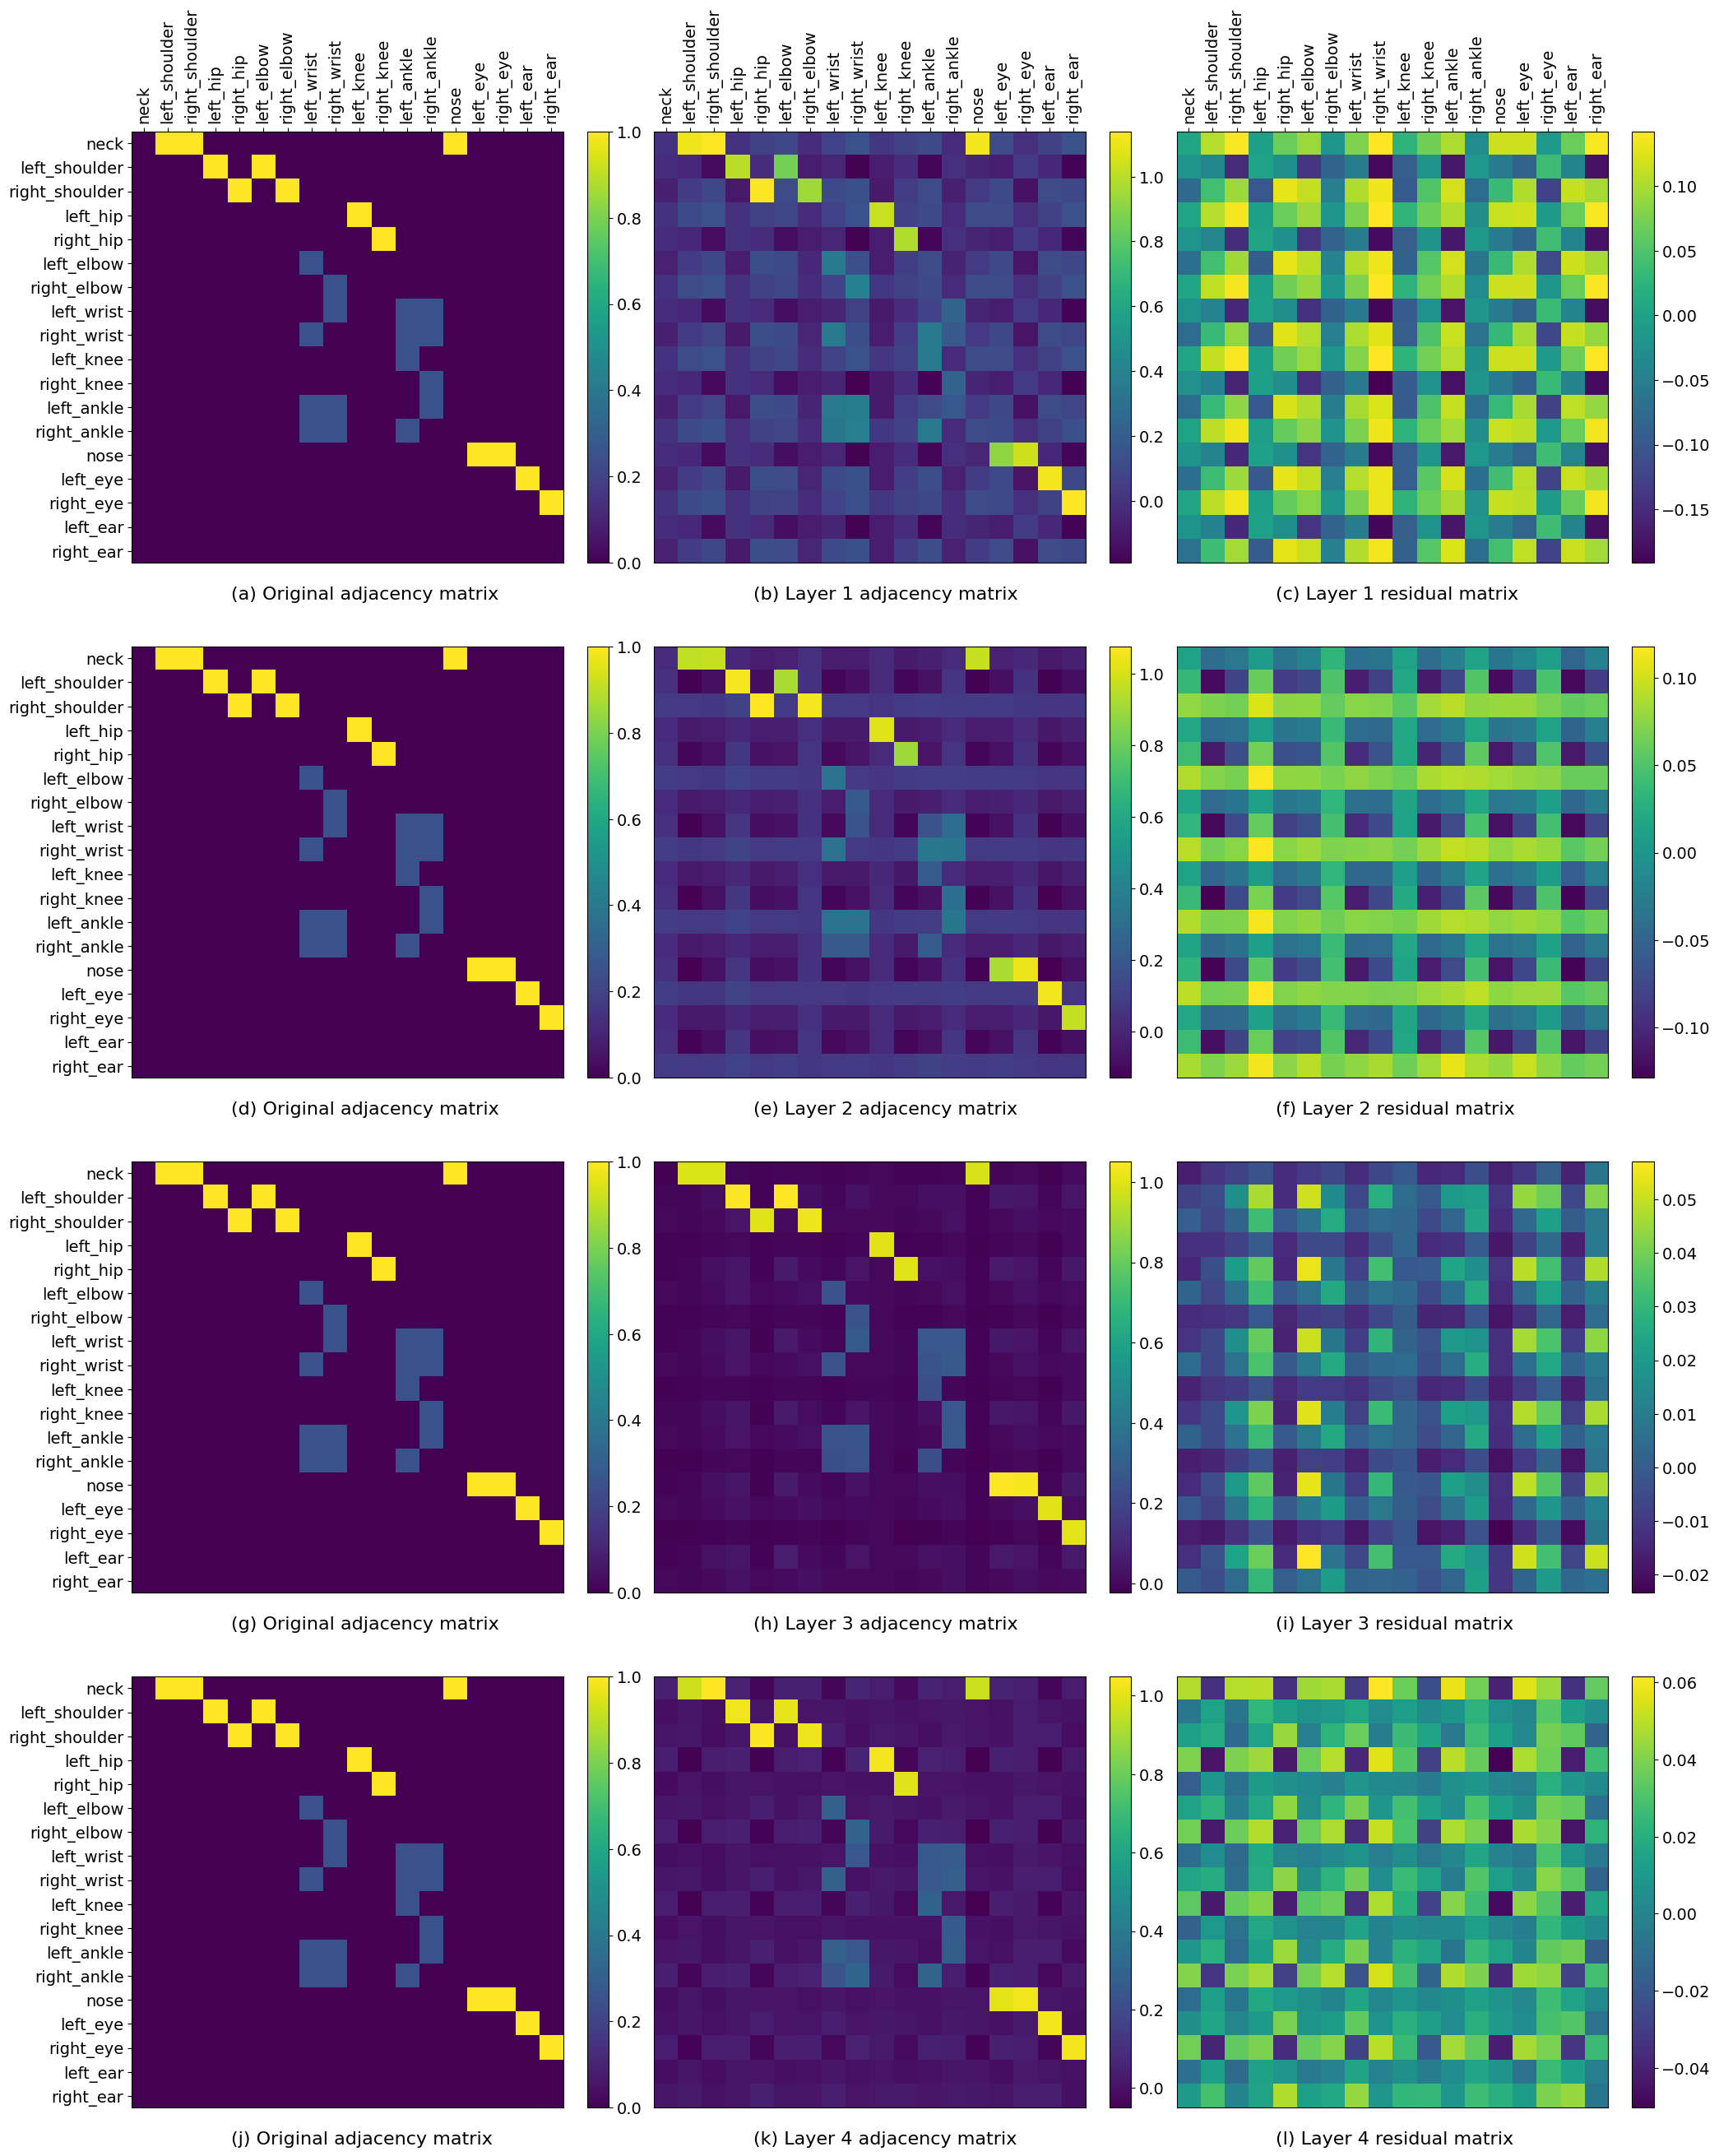

In [8]:
def plot_adjacency_matrix(ax, A, label_letter, matrix_type, layer_num, add_xlabel, add_ylabel):
    cax = ax.matshow(A, cmap='viridis', interpolation='none')
    cbar = fig.colorbar(cax, ax=ax, fraction=0.0452, pad=0.05)
    cbar.ax.tick_params(labelsize=14)
    
    if add_xlabel:
        labels = list(NODE_INDEX.keys())
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=90, fontsize=14)
        ax.tick_params(axis='x', bottom=False)
    else:
        ax.set_xticks([])

    if add_ylabel:
        labels = list(NODE_INDEX.keys())
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels, fontsize=14)
    else:
        ax.set_yticks([])

    if matrix_type == 'original':
        axis_text = f'({label_letter}) Original adjacency matrix'
    elif matrix_type == 'learned':
        axis_text = f'({label_letter}) Layer {layer_num+1} adjacency matrix'
    else:
        axis_text = f'({label_letter}) Layer {layer_num+1} residual matrix'

    ax.text(0.23, -0.085, axis_text, transform=ax.transAxes, fontsize=16)


fig, axs = plt.subplots(4, 3, figsize=(21, 28))

for i in range(len(learned_graphs)):
    # Original Graph for each layer
    label_letter = string.ascii_lowercase[i * 3]
    plot_adjacency_matrix(axs[i, 0], original_graph[1, :, :], label_letter, 'original', i, add_xlabel=(i==0), add_ylabel=True)

    # Learned Graph for each layer
    label_letter = string.ascii_lowercase[i * 3 + 1]
    plot_adjacency_matrix(axs[i, 1], learned_graphs[i][1, :, :], label_letter, 'learned', i, add_xlabel=(i==0), add_ylabel=False)

    # Difference for each layer
    label_letter = string.ascii_lowercase[i * 3 + 2]
    diff = learned_graphs[i][1, :, :] - original_graph[1, :, :]
    plot_adjacency_matrix(axs[i, 2], diff, label_letter, 'residual', i, add_xlabel=(i==0), add_ylabel=False)    

plt.tight_layout()

fig.subplots_adjust(hspace=-0.15)

for ext in ['png', 'pdf', 'eps']:
    plt.savefig(f'figures/all_adjacency_matrices.{ext}', dpi=300)

plt.show()

## Plot Learned Graphs and Attention

In [9]:
prediction_ids = age_data.test_id.values
prediction_fts = fts_data[fts_data['test_id'].isin(prediction_ids)]

prediction_dataset = InfantMotionDataset(args['data_dir'], prediction_fts, streams, xy_data=xy_data, predict=True)
prediction_loader = DataLoader(prediction_dataset, batch_size=1, num_workers=1)

In [10]:
prediction_fts

,segment,test_id,outcome,corrected_age,hands_position_cca_z,feet_position_cca_z,hands_angles_cca_vec,feet_angles_cca_vec,hands_v_corr_z,feet_v_corr_z,...,hands_close_prob,feet_close_prob,hands_lift_prob,feet_lift_prob,hands_activity,hands_mobility,hands_complexity,feet_activity,feet_mobility,feet_complexity
0,v63_1_9,v63,0,135,0.298131,0.864937,1.073053,0.212958,0.144398,0.827106,...,0.319601,0.552629,0.879889,0.044911,0.002688,0.006520,0.384195,0.331816,2.034340,2.210027
1,0078_2_7,0078,0,117,0.121431,0.540297,2.039207,0.184360,0.523759,0.723712,...,0.908468,0.934996,0.972944,0.476283,0.001852,0.003995,0.443954,0.399443,1.846396,2.001339
2,0028_1_9,0028,1,91,-0.136205,0.222133,2.484061,0.127616,0.184767,0.512884,...,0.701367,0.898431,0.923739,0.242619,0.004314,0.003018,0.381250,0.382515,2.016825,1.939391
3,v30_5_5,v30,0,104,0.199978,0.387210,0.684571,0.095049,0.389825,0.820785,...,0.396880,0.859422,0.505625,0.356550,0.011028,0.006796,0.446642,0.387933,1.807391,1.933277
4,0089_2_7,0089,0,95,0.020637,0.665044,0.128481,0.567511,0.274843,0.316880,...,0.573312,0.801540,0.793543,0.584123,0.001450,0.003496,0.413658,0.383355,1.906969,2.019783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,0058_1_8,0058,0,91,-0.225890,0.859977,1.792007,0.471017,0.202711,1.177827,...,0.616792,0.946648,0.857558,0.602257,0.001747,0.006724,0.437013,0.403457,1.848241,1.992826
1886,0058_1_0,0058,0,91,-0.225890,0.859977,1.792007,0.471017,0.202711,1.177827,...,0.616792,0.946648,0.857558,0.602257,0.001747,0.006724,0.437013,0.403457,1.848241,1.992826
1887,0051_2_5,0051,0,92,0.042011,0.665083,0.794497,0.067724,0.315098,0.650069,...,0.013258,0.844318,0.228220,0.865909,0.003682,0.006204,0.437304,0.363403,1.784642,2.040989
1888,0011_1_9,0011,0,103,-0.108152,0.157440,1.219561,0.516766,0.036060,0.730028,...,0.436647,0.899263,0.428796,0.480734,0.005121,0.004228,0.446643,0.426423,1.802441,1.886827


In [11]:
times = []

for i, batch in enumerate(prediction_loader):
    
    with torch.no_grad():
        X, y, fts = batch
        
        start_time = time.time()
        y_pred = model(X, fts)
        end_time = time.time()

    times.append(end_time - start_time)

    if i == 51:
        break

In [12]:
print(np.mean(times[1:]), np.std(times[1:]))

0.07134607726452398 0.012354253591589554


In [13]:
results = {}

iterations = 2

for i, batch in tqdm(enumerate(prediction_loader), total=iterations-1):
    start_time = time.time()
    
    with torch.no_grad():
        X, y, fts = batch
        y_pred = model(X, fts)
        
    end_time = time.time()
    
    segment = prediction_fts.iloc[i].segment
    fname = Path(args['data_dir'], f'{segment}.feather')
    
    if segment.startswith('v'):
        location = 'helsinki'
    else:
        location = 'pisa'
    
    df = pd.read_csv(os.path.join('data', 'rotated', location, fname.name.replace('feather', 'csv')))
    mean_graph = df.mean()

    # Storing data in the dictionary for each layer
    results[segment] = {
        'age': y.squeeze().numpy().astype(int),
        'predicted_age': y_pred.squeeze().numpy().astype(int),
        'mean_graph': mean_graph,
        'video': df[5:-5],
        'inference_time': end_time - start_time,
    }

    for layer, layer_name in [(model.l1, 'layer_1'), (model.l2, 'layer_2'), (model.l3, 'layer_3'), (model.l4, 'layer_4')]:
        self_edges, inward_edges, outward_edges = layer.learned_graphs
        ms, mt, mc = layer.learned_attention

        results[segment][layer_name] = {
            'inward_edges': inward_edges.squeeze(),
            'outward_edges': outward_edges.squeeze(),
            'self_edges': self_edges.squeeze(),
            'spatial_attention': ms.squeeze(),
            'temporal_attention': mt.squeeze(),
            'channel_attention': mc.squeeze(),
        }

    if i == iterations - 1:
        break

  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
def min_max_normalize(values):
    min_val = np.min(values)
    max_val = np.max(values)
    if (max_val == min_val):
        return values
    return (values - min_val) / (max_val - min_val)

def get_graph(row, A=None):
    G = nx.Graph()
    graph_bodyparts = list(NODE_INDEX.keys())
    
    for bodypart in graph_bodyparts:
        G.add_node(NODE_INDEX[bodypart],
                   x=row[f'{bodypart}_x'],
                   y=row[f'{bodypart}_y'],
                   z=row[f'{bodypart}_z'],
                   label=bodypart
        )
    
    if A is not None:
        min_weight = A.min().item()
        max_weight = A.max().item()

    for label_0, label_1 in EDGE_LABELS:
        original_weight = A[NODE_INDEX[label_0], NODE_INDEX[label_1]] if A is not None else 1
        
        if A is not None:
            weight = (original_weight - min_weight) / (max_weight - min_weight)
        else:
            weight = 1

        G.add_edge(NODE_INDEX[label_0], NODE_INDEX[label_1], weight=weight)
    
    return G

def plot_graph(ax, row, layer, edge_weights):
    G = get_graph(row, edge_weights)

    x = nx.get_node_attributes(G, 'x')
    y = nx.get_node_attributes(G, 'y')
    z = nx.get_node_attributes(G, 'z')

    pos = {}
    for node in G.nodes:
        pos[node] = (x[node], y[node], z[node])

    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    ax.scatter(*node_xyz.T, s=30, ec='w', c='gray')

    # Plot real edges with default gray color
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color='gray')

    # Get the top impactful edges from edge_weights
    num_edges = len(EDGE_LABELS)
    flat_indices = np.argpartition(edge_weights.flatten(), -num_edges)[-num_edges:]
    row_indices, col_indices = np.unravel_index(flat_indices, edge_weights.shape)
    impactful_edges = [(row, col) for row, col in zip(row_indices, col_indices)]
    impactful_weights = [edge_weights[row, col] for row, col in impactful_edges]

    # Normalize impactful_weights based on their own min and max
    min_impactful_weight = min(impactful_weights)
    max_impactful_weight = max(impactful_weights)
    # normalized_impactful_weights = [(weight - min_impactful_weight) / (max_impactful_weight - min_impactful_weight) for weight in impactful_weights]

    min_threshold = 0.15
    normalized_impactful_weights = [
        (weight - min_impactful_weight) / (max_impactful_weight - min_impactful_weight)
        for weight in impactful_weights
    ]
    # Rescale weights to [min_threshold, 1]
    rescaled_impactful_weights = [
        min_threshold + (1 - min_threshold) * weight for weight in normalized_impactful_weights
    ]
    impactful_colors = [plt.cm.YlOrRd(weight) for weight in rescaled_impactful_weights]

    # Plot impactful edges
    for (node1, node2), color in zip(impactful_edges, impactful_colors):
        ax.plot([x[node1], x[node2]], [y[node1], y[node2]], [z[node1], z[node2]], color=color, lw=2)

    def _format_axes(ax):
        # ax.grid(False)
        
        ax.xaxis.pane.set_facecolor('#FBFBFB')
        ax.yaxis.pane.set_facecolor('#F4F4F4')
        ax.zaxis.pane.set_facecolor('#FBFBFB')
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        
        ax.xaxis.pane.set_edgecolor('none')
        ax.yaxis.pane.set_edgecolor('none')
        ax.zaxis.pane.set_edgecolor('none')


        ax.grid(True)
        grid_color = '#DCDCDC'
        
        ax.xaxis._axinfo["grid"].update(color=grid_color, linestyle='-')
        ax.yaxis._axinfo["grid"].update(color=grid_color, linestyle='-')
        ax.zaxis._axinfo["grid"].update(color=grid_color, linestyle='-')
    
        #ax.xaxis.pane.set_facecolor('#FCFCFC')
        #ax.yaxis.pane.set_facecolor('#F4F4F4')
        #ax.zaxis.pane.set_facecolor('#FCFCFC')
    
    _format_axes(ax)

def plot_temporal_attention(data, segment):
    fig = plt.figure(figsize=(6, 4.8))
    ax = fig.add_subplot()

    for layer_num in [1, 2, 3, 4]:
        layer_name = f'layer_{layer_num}'
        layer_data = data[layer_name]
        ax.plot(min_max_normalize(layer_data['temporal_attention']), label=f'Layer {layer_num}')

    ax.set_xlabel('Time steps')
    ax.set_ylabel('Normalized attention weight')

    plt.tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True)
    plt.minorticks_on()

    ax.set_yscale('log')

    major_ticks = np.power(10.0, np.arange(0, -19, -3))
    ax.set_yticks(major_ticks)

    minor_ticks = np.power(10.0, np.arange(-1, -20, -1))
    ax.set_yticks(minor_ticks, minor=True)
    ax.yaxis.set_minor_formatter(plt.NullFormatter())

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fancybox=True, frameon=False)

    plt.tight_layout()
    
    for ext in ['png', 'pdf', 'eps']:
        plt.savefig(f'figures/temporal_attention_{segment}.{ext}', dpi=300)
    
    plt.show()
    
def plot_channel_attention(channel_attention, layer):
    plt.figure()
    plt.bar(range(len(channel_attention)), channel_attention)
    plt.title(f'Channel attention for layer: {layer}')
    plt.xlabel('Channels')
    plt.ylabel('Attention weight')
    plt.show()

Input v63_1_9 y 135 ŷ 144 t 0.07778429985046387


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


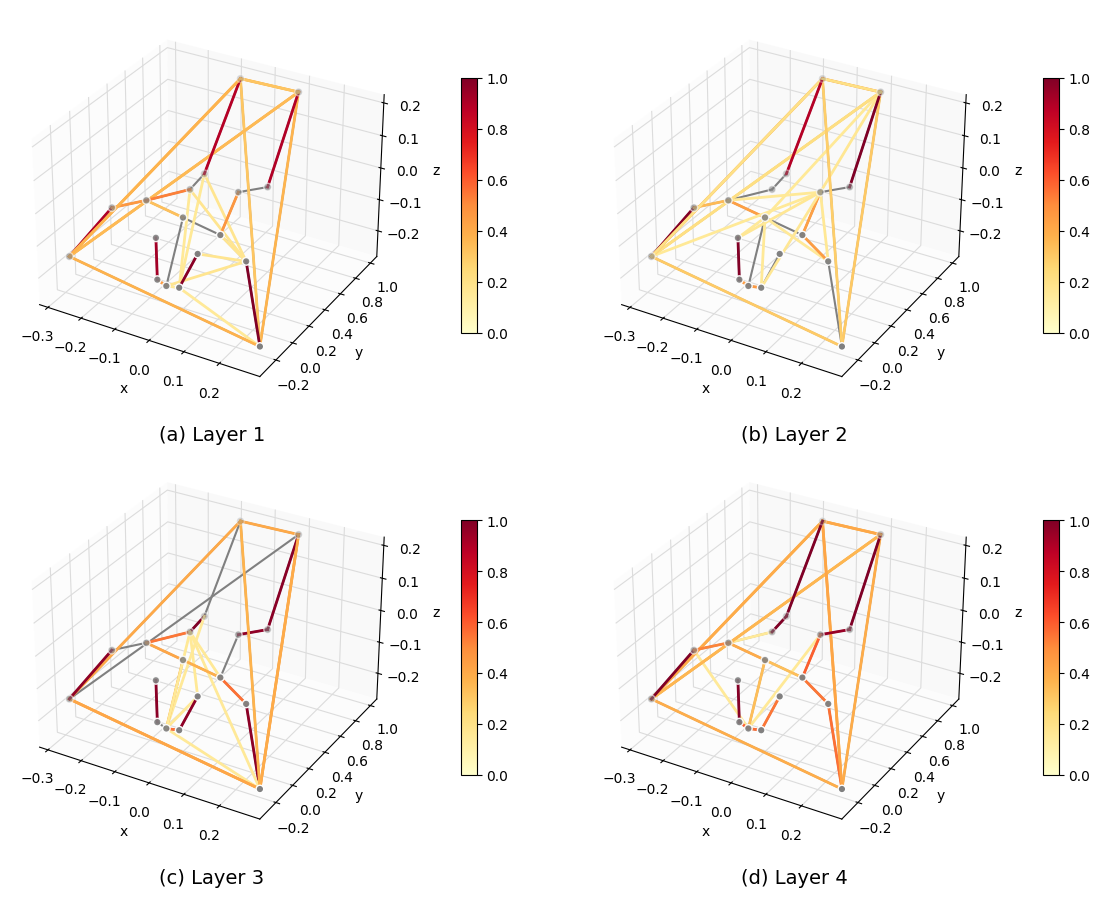

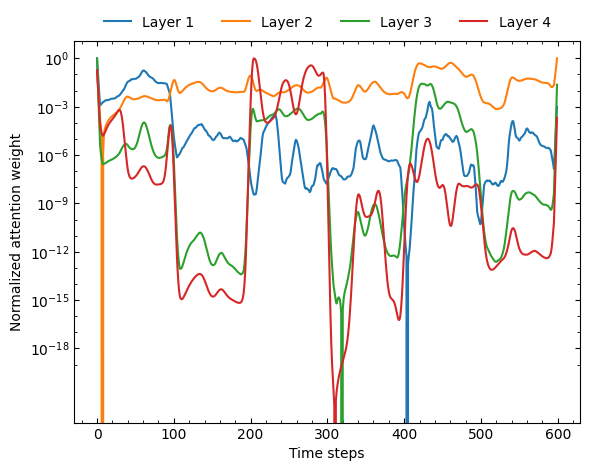

Input 0078_2_7 y 117 ŷ 97 t 0.06091165542602539


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


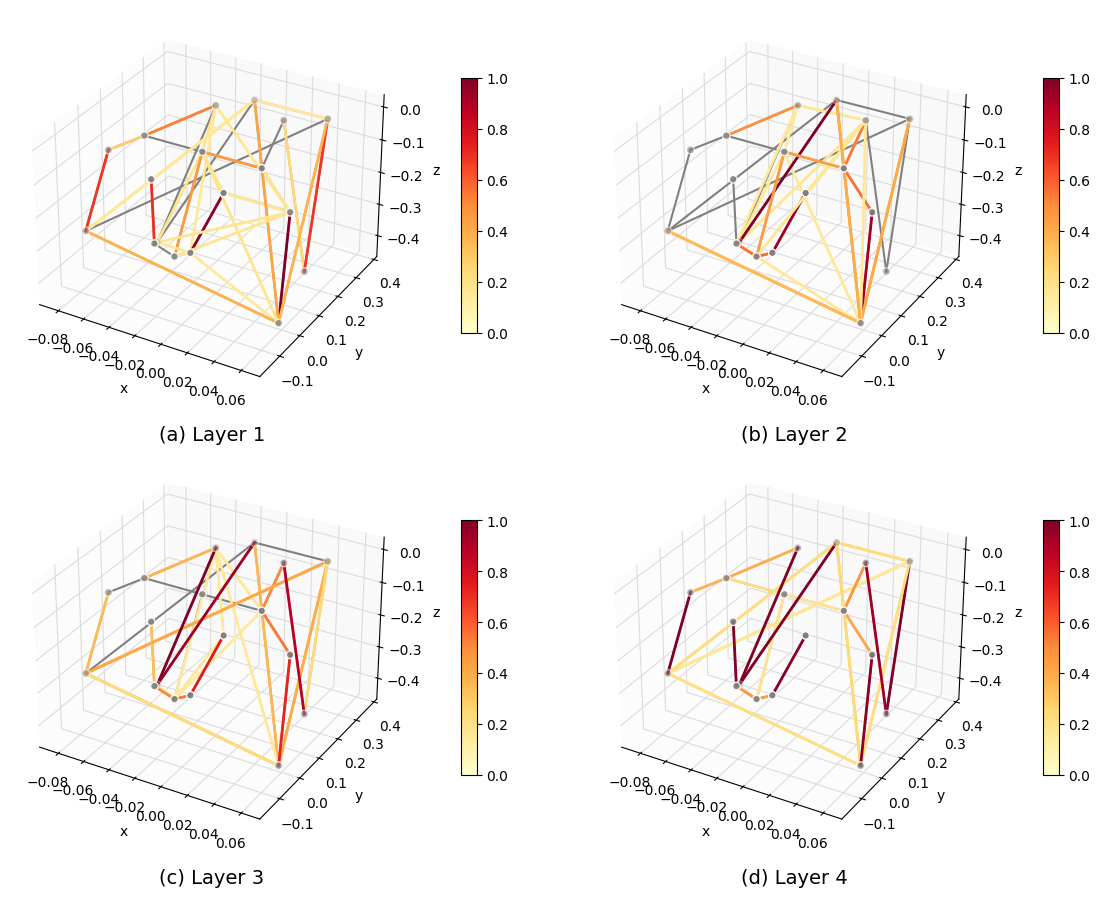

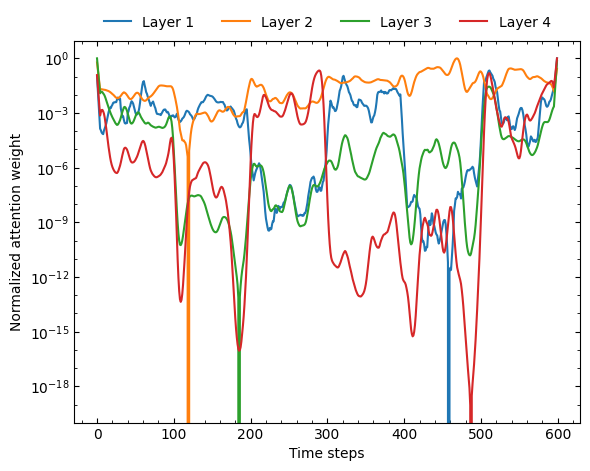

In [15]:
for segment, data in results.items():
    age = data['age']
    predicted_age = data['predicted_age']
    mean_graph_data = data['mean_graph']
    video = data['video']
    inference_time = data['inference_time']
    
    print(f'Input {segment}', 'y', age, 'ŷ', predicted_age, 't', inference_time)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 9), subplot_kw={'projection': '3d'})
    axs = axs.ravel()
    
    num_to_letter = {1: 'a', 2: 'b', 3: 'c', 4: 'd'}
    
    for layer_num in range(1, 5):
        layer_name = f'layer_{layer_num}'
        layer_data = data[layer_name]
        edge_weights = layer_data['outward_edges']
        normalized_weights = min_max_normalize(edge_weights.flatten())

        # Plot infant graph with learned edge weights on the subplot
        scatter = plot_graph(axs[layer_num-1], mean_graph_data, layer_num, edge_weights)
        sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array([])
        fig.colorbar(sm, ax=axs[layer_num-1], shrink=0.65, aspect=16, pad=0.1)
        
        axs[layer_num-1].text2D(
            0.38, -0.1, f'({num_to_letter[layer_num]}) Layer {layer_num}', 
            transform=axs[layer_num-1].transAxes, fontsize=14)
        
        # Optionally, plot channel attention here or in a separate figure
        # plot_channel_attention(layer_data['channel_attention'], layer_num)
    
    plt.tight_layout()
    
    for ext in ['png', 'pdf', 'eps']:
        plt.savefig(f'figures/learned_graphs_{segment}.{ext}', dpi=300)
    plt.show()

    # Temporal attention plot
    plot_temporal_attention(data, segment)

## Animation

In [16]:
import imageio.v2 as imageio

def plot_temporal_attention(temporal_attention, segment):
    plt.figure()
    
    for layer_num in [4]:
        layer_name = f'layer_{layer_num}'
        layer_data = data[layer_name]
        plt.plot(min_max_normalize(temporal_attention), label=f'Layer {layer_num}')
        
    plt.title(f'Temporal Attention for Segment: {segment}')
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Attention Weight')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/{segment}/temporal_attention.png')

def min_max_normalize(values):
    min_val = np.min(values)
    max_val = np.max(values)
    
    return (values - min_val) / (max_val - min_val)

def get_graph(row, A=None):
    G = nx.Graph()
    graph_bodyparts = list(NODE_INDEX.keys())
    
    for bodypart in graph_bodyparts:
        G.add_node(NODE_INDEX[bodypart],
                   x=row[f'{bodypart}_x'],
                   y=row[f'{bodypart}_y'],
                   z=row[f'{bodypart}_z'],
                   label=bodypart
        )
    
    if A is not None:
        min_weight = A.min().item()
        max_weight = A.max().item()

    for label_0, label_1 in EDGE_LABELS:
        original_weight = A[NODE_INDEX[label_0], NODE_INDEX[label_1]] if A is not None else 1
        
        if A is not None:
            weight = (original_weight - min_weight) / (max_weight - min_weight)
        else:
            weight = 1

        G.add_edge(NODE_INDEX[label_0], NODE_INDEX[label_1], weight=weight)
    
    return G

def plot_graph(row, learned_weights, layer, frame, attention, test_id, age, predicted_age):
    G = get_graph(row, learned_weights)

    x = nx.get_node_attributes(G, 'x')
    y = nx.get_node_attributes(G, 'y')
    z = nx.get_node_attributes(G, 'z')

    pos = {}
    for node in G.nodes:
        pos[node] = (x[node], y[node], z[node])

    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])
    edge_weights = list(nx.get_edge_attributes(G, 'weight').values())
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(True)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(global_min_x, global_max_x)
    ax.set_ylim(global_min_y, global_max_y)
    ax.set_zlim(global_min_z, global_max_z)
    
    ax.scatter(*node_xyz.T, s=30, ec='w', c='gray')
    
    ax.set_title(f'id: {test_id}, age: {age}, pred: {predicted_age}, attention: {attention:.4f}')
    
    edge_colors = plt.cm.Reds(edge_weights)

    for vizedge, color in zip(edge_xyz, edge_colors):
        ax.plot(*vizedge.T, color=color)

    plt.tight_layout()
    plt.savefig(f'figures/{segment}/{frame}.png')
    plt.close(fig)

for segment, data in results.items():
    os.makedirs(f'figures/{segment}', exist_ok=True)

    age = data['age']
    predicted_age = data['predicted_age']
    mean_graph_data = data['mean_graph']
    video = data['video']
    
    test_id = segment.split('_')[0]

    global_x = np.concatenate([video[f'{bp}_x'].values for bp in NODE_INDEX.keys()])
    global_y = np.concatenate([video[f'{bp}_y'].values for bp in NODE_INDEX.keys()])
    global_z = np.concatenate([video[f'{bp}_z'].values for bp in NODE_INDEX.keys()])

    global_min_x, global_max_x = global_x.min(), global_x.max()
    global_min_y, global_max_y = global_y.min(), global_y.max()
    global_min_z, global_max_z = global_z.min(), global_z.max()

    for layer_num in [4]:
        layer_name = f'layer_{layer_num}'
        layer_data = data[layer_name]
        temporal_attention = min_max_normalize(layer_data['temporal_attention'])

        edge_weights = layer_data['outward_edges']

        for frame in tqdm(range(len(video))):
            plot_graph(video.iloc[frame], edge_weights, layer, frame, temporal_attention[frame], test_id, age, predicted_age)
    
    # Animate image sequence
    filenames = [f'figures/{segment}/{i}.png' for i in range(len(video))]
    with imageio.get_writer(f'figures/{segment}/animation.mp4', mode='I', fps=10) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

  0%|          | 0/564 [00:00<?, ?it/s]

  0%|          | 0/559 [00:00<?, ?it/s]